# Predict the DISPOSITION_CHARGED_CLASS of defendants

In [1]:
# Import basic functionality
import pandas as pd
import numpy as np
!pip install gender_guesser
!pip install xlrd
!pip install openpyxl
import gender_guesser.detector as gender
import re

In [2]:
# Read the data
df = pd.read_csv("/Users/leowu/Desktop/Study_Materials/Data_Science1/pset2_inputdata/sentencing_asof0405.csv")
police_stations = pd.read_csv('/Users/leowu/Desktop/Final-Project-Group5/Dataset/Police_Stations.csv')
# Clean the df, subset the PRIMARY_CHARGE_FLAG == True
df1 = df[df.PRIMARY_CHARGE_FLAG == True]

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_20213/2811122065.py:2: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/leowu/Desktop/Study_Materials/Data_Science1/pset2_inputdata/sentencing_asof0405.csv")


In [3]:
print(df1.shape)
df1.head()

(180625, 41)


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
9,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
10,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
15,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,NaN,2/10/1983 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,2/10/1983 12:00:00 AM,NaN,NaN,NaN,Homicide
16,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,NaN,2/10/1983 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,2/10/1983 12:00:00 AM,NaN,NaN,NaN,Homicide
18,154954734978,225758446387,6/8/2001 12:00:00 AM,PROMIS Conversion,True,54885211141,174293345821,VIO BAIL BOND/CLASS 1,1,12/2/2013 12:00:00 AM,...,NaN,4/24/2001 12:00:00 AM,NaN,HANOVER PARK POLICE DEPARTMENT,NaN,10/26/2000 12:00:00 AM,NaN,NaN,NaN,PROMIS Conversion


## Introduce the independant variables
### Race variables

In [4]:
## Pre-clean
df1 = df1[~df1.RACE.isna()]

In [5]:
# Create is_black_derived, is_white_derived, is_hisp_derived, is_other_derived variables
df1['is_black_derived'] = np.where(df1.RACE == 'Black', True, False)
df1['is_white_derived'] = np.where(df1.RACE == 'White', True, False)
df1['is_hisp_derived'] = np.where(df1.RACE == 'HISPANIC', True, False)
df1['is_other_derived'] = np.where(~df1.RACE.isin(['Black','White','HISPANIC']), True, False)

### Gender variables

In [6]:
## Pre-clean
df1 = df1[(df1.GENDER.isin(['Male','Female']))& (~df1.SENTENCE_JUDGE.isna())]

In [7]:
# Create is_defendant_male variable
df1['is_defendant_male'] = np.where(df1.GENDER == 'Male', True, False)

In [8]:
# Create is_judge_male variable

### Get the first name of judgers
df1['FN_judge'] = [i.split(' ')[0] for i in df1['SENTENCE_JUDGE']]

### Predict the judgers' genders
gd = gender.Detector()
df1['Gender_judge'] = df1['FN_judge'].\
apply(str.capitalize).map(lambda x: gd.get_gender(x))

### To see the diffence of judge made by judgers with different genders
df1.groupby('Gender_judge').agg(num_judge = ('Gender_judge', 'count')).reset_index()

,Gender_judge,num_judge
0,andy,114
1,female,44056
2,male,117728
3,mostly_female,12517
4,mostly_male,6
5,unknown,4566


In [9]:
### Rename the is_judge_gender
df1 = df1[df1.Gender_judge.isin(['female','male','mostly_female','mostly_male'])]
df1['is_judge_male'] = np.where(df1.Gender_judge.isin(['mostly_male','male']), True, False)

In [10]:
df1[['SENTENCE_JUDGE','FN_judge','is_judge_male','Gender_judge']].head()

,SENTENCE_JUDGE,FN_judge,is_judge_male,Gender_judge
9,Clayton Jay Crane,Clayton,True,male
10,John Mannion,John,True,male
15,James L Rhodes,James,True,male
16,Thomas V Gainer,Thomas,True,male
18,Kay M Hanlon,Kay,True,male


### is_changed_offense variable
Add a variable called is_changed_offense to research whether the change in offense type will influnece the incarceration condition

In [11]:
df1['is_changed_offense'] = (df1['OFFENSE_CATEGORY'] == df1['UPDATED_OFFENSE_CATEGORY'])

### is_covid variable
Add a variable called is_covid to research the influence of covid.

We select 2020 as the seperate line, <2020 is False, >=2020 is True.

In [12]:
# Use regex to clean up the date columns
df1 = df1[~df1.ARREST_DATE.isna()]
df1["ARREST_DATE"]  = [re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date)) 
                                               if bool(re.search('\/2[1-9][0-9]+', str(date))) else 
                                               str(date) 
                                               for date in 
                                               df1["ARREST_DATE"]]
df1["ARREST_DATE"].head()

9      8/15/1984 12:00:00 AM
10     8/15/1984 12:00:00 AM
15     2/10/1983 12:00:00 AM
16     2/10/1983 12:00:00 AM
18    10/26/2000 12:00:00 AM
Name: ARREST_DATE, dtype: object

In [13]:
# Transfer date to datetime 
df1["ARREST_DATE"] = pd.to_datetime(df1.ARREST_DATE)                                                  
# Extract the arrest year
df1["arrest_year"] = df1["ARREST_DATE"].dt.year
df1["arrest_year"].head()

9     1984
10    1984
15    1983
16    1983
18    2000
Name: arrest_year, dtype: int64

In [14]:
df1["is_covid"] = np.where(df1["arrest_year"]>=2020 , True, False)
df1["is_covid"].head()

9     False
10    False
15    False
16    False
18    False
Name: is_covid, dtype: bool

### Add livability index
Livability from website: https://www.areavibes.com/

In [15]:
### Read the file
police_stations = pd.read_csv('/Users/leowu/Desktop/Final-Project-Group5/Dataset/Police_Stations.csv')
police_stations['NEIGHBORHOODS'] = ['Douglas','Near North Side','Lake View','Lincoln Square','Morgan Park',\
                                   'Rogers Park','Belmont Cragin','Near South Side','Fuller Park',\
                                   'Woodlawn','South Deering','Pullman','Auburn Gresham','West Englewood',\
                                   'Chicago Lawn','Bridgeport','North Lawndale','East Garfield Park',\
                                   'Near West Side','Logan Square','Austin','Jefferson Park','Jefferson Park']
new_df = df1[~df1['LAW_ENFORCEMENT_UNIT'].isnull()]

In [16]:
new_df_count = new_df.groupby('LAW_ENFORCEMENT_UNIT').agg(COUNT = ('CASE_ID','count')).\
sort_values('COUNT',ascending = False).reset_index()
new_df_up = new_df_count[new_df_count.LAW_ENFORCEMENT_UNIT.str.contains('District')].\
reset_index().drop(columns=['index'])
new_df_up['DISTRICT NAME'] = [new_df_up.LAW_ENFORCEMENT_UNIT.str.split(' - ')[i][1] for i in range(len(new_df_up))]
new_df_up.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME
0,District 11 - Harrison,13229,Harrison
1,District 10 - Ogden,4417,Ogden
2,District 15 - Austin,4242,Austin
3,District 7 - Englewood,3399,Englewood
4,District 6 - Gresham,3012,Gresham


In [17]:
new_df_con = pd.merge(new_df_up,
                     police_stations[['DISTRICT NAME','LATITUDE','LONGITUDE','NEIGHBORHOODS']],
                     how = 'inner',
                     on = 'DISTRICT NAME')
new_df_con.head()

,LAW_ENFORCEMENT_UNIT,COUNT,DISTRICT NAME,LATITUDE,LONGITUDE,NEIGHBORHOODS
0,District 11 - Harrison,13229,Harrison,41.873582,-87.705488,East Garfield Park
1,District 10 - Ogden,4417,Ogden,41.856685,-87.708382,North Lawndale
2,District 15 - Austin,4242,Austin,41.880083,-87.768200,Austin
3,District 7 - Englewood,3399,Englewood,41.779632,-87.660887,West Englewood
4,District 6 - Gresham,3012,Gresham,41.752137,-87.644229,Auburn Gresham


In [18]:
new_df_con['Livability'] = [62, 51, 60, 56, 58, 64, 58, 56, 66, 55, 54, 57, 63, 68,63, 73, 73, 55, 76, 76, 67, 69]
### Merge these two dataframes together
df1 = pd.merge(df1,
        new_df_con[['Livability','LAW_ENFORCEMENT_UNIT']],
        how='inner',
        on='LAW_ENFORCEMENT_UNIT')
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_hisp_derived,is_other_derived,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,arrest_year,is_covid,Livability
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,True,False,False,Catherine,female,False,False,2010,False,64
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,False,False,True,James,male,True,False,2010,False,64
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,False,False,True,Sharon,female,False,True,2010,False,64
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,False,False,Maura,female,False,True,2010,False,64
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,False,False,True,James,male,True,False,2010,False,64


### Add Arrest police station history record index
In detailed, it refers to the proportion of different police station history record number

In [19]:
new_df_con['his_prop'] = new_df_con.COUNT / new_df_con.COUNT.sum()

In [20]:
df1 = pd.merge(df1,
                new_df_con[['his_prop','LAW_ENFORCEMENT_UNIT']],
                how='inner',
                on='LAW_ENFORCEMENT_UNIT')
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_other_derived,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,arrest_year,is_covid,Livability,his_prop
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,False,False,Catherine,female,False,False,2010,False,64,0.058098
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,False,True,James,male,True,False,2010,False,64,0.058098
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,False,True,Sharon,female,False,True,2010,False,64,0.058098
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,False,Maura,female,False,True,2010,False,64,0.058098
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,False,True,James,male,True,False,2010,False,64,0.058098


### Add senlength (unit: year) variable

In [21]:
## Clean the data
df1 = df1[(~df1.COMMITMENT_TERM.isna())&\
          (df1.COMMITMENT_UNIT.isin(['Days','Hours','Year(s)','Months','Weeks','Natural Life']))&\
          (~df1.AGE_AT_INCIDENT.isna())]

In [22]:
# Change the units to year
def transition(df: pd.DataFrame):
    df['senlength_derived'] = [float(u)
      if v == 'Year(s)'
      else float(float(u) / (24*365)) 
           if v == 'Hours'
           else float(float(u)/ 365) 
                if v == 'Days'
                else float(float(u)/ 12) 
                    if v == 'Months'
                    else float(float(u) *7 / 365) 
                        if v == 'Weeks'
                        else float(100-20)
                               if (v == 'Natural Life') & (np.isnan(i))
                               else float(100-float(i)) 
      for u,v,i in zip(df.COMMITMENT_TERM,df.COMMITMENT_UNIT,df.AGE_AT_INCIDENT)]
    
    return df

In [23]:
df1 = transition(df = df1)
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_defendant_male,FN_judge,Gender_judge,is_judge_male,is_changed_offense,arrest_year,is_covid,Livability,his_prop,senlength_derived
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,False,Catherine,female,False,False,2010,False,64,0.058098,2.0
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,True,James,male,True,False,2010,False,64,0.058098,2.0
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,True,Sharon,female,False,True,2010,False,64,0.058098,2.0
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,False,Maura,female,False,True,2010,False,64,0.058098,3.0
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,True,James,male,True,False,2010,False,64,0.058098,15.0


In [24]:
## Clean the abnormal value
df1.senlength_derived.describe()
## Select 100 as maximum sentence length
df1 = df1[df1.senlength_derived < 100]

### Add Incar variable
We regarded the defendant whose COMMITMENT_TYPE is Illinois Department of Corrections as incarceration.

In [25]:
df1.COMMITMENT_TYPE.value_counts().head(5)

Illinois Department of Corrections       25979
Probation                                15924
710/410 Probation                         3312
Cook County Department of Corrections     1566
Intensive Probation Services              1072
Name: COMMITMENT_TYPE, dtype: int64

In [26]:
df1['Incar'] = np.where(df1.COMMITMENT_TYPE == 'Illinois Department of Corrections', True , False)
df1.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,FN_judge,Gender_judge,is_judge_male,is_changed_offense,arrest_year,is_covid,Livability,his_prop,senlength_derived,Incar
0,240624757473,214083848061,2/7/2010 12:00:00 AM,PROMIS Conversion,True,190929352317,255873414267,UUW/FELONY POSS/USE WEAPON/FIREARM,1,1/21/2011 12:00:00 AM,...,Catherine,female,False,False,2010,False,64,0.058098,2.0,False
1,377335736568,694901143919,4/17/2010 12:00:00 AM,Sex Crimes,True,333676612023,620025653522,VIOLATION OF THE SEX OFFENDER REGISTRATION ACT,1,5/16/2011 12:00:00 AM,...,James,male,True,False,2010,False,64,0.058098,2.0,True
2,377394331582,695079507410,4/21/2010 12:00:00 AM,Narcotics,True,334341207520,621377822772,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/12/2011 12:00:00 AM,...,Sharon,female,False,True,2010,False,64,0.058098,2.0,False
3,377427373884,695175012095,4/8/2010 12:00:00 AM,Narcotics,True,333825227220,620352718918,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,4/12/2011 12:00:00 AM,...,Maura,female,False,True,2010,False,64,0.058098,3.0,True
4,377478919873,695306378222,4/24/2010 12:00:00 AM,Attempt Arson,True,334053278144,620821129628,AGGRAVATED ARSON,1,7/29/2011 12:00:00 AM,...,James,male,True,False,2010,False,64,0.058098,15.0,True


## Create a new df to research our prediction model
### We also selected 3 existing variables from the data set to research, including CHARGE_COUNT, DISPOSITION_CHARGED_CLASS and AGE_AT_INCIDENT.

In [27]:
new_df = df1[['CHARGE_COUNT', 'AGE_AT_INCIDENT',\
             'is_changed_offense','is_black_derived','is_hisp_derived','is_other_derived',\
             'is_white_derived','is_defendant_male','is_judge_male',\
            'is_covid','Livability','his_prop','senlength_derived','Incar','DISPOSITION_CHARGED_CLASS']]
new_df = new_df[(~new_df.CHARGE_COUNT.isna()) &
               (new_df.DISPOSITION_CHARGED_CLASS.isin(['1','2','3','4','X','M']))&
               (~new_df.AGE_AT_INCIDENT.isna())]
new_df.head()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,Livability,his_prop,senlength_derived,Incar,DISPOSITION_CHARGED_CLASS
0,1,26.0,False,False,True,False,False,False,False,False,64,0.058098,2.0,False,2
1,1,55.0,False,True,False,False,False,True,True,False,64,0.058098,2.0,True,3
2,1,27.0,True,True,False,False,False,True,False,False,64,0.058098,2.0,False,3
3,1,52.0,True,True,False,False,False,False,False,False,64,0.058098,3.0,True,1
4,1,55.0,False,True,False,False,False,True,True,False,64,0.058098,15.0,True,X


In [28]:
## Write a function to tranfer bool type to binary variables
def tran(a):
    new_df[a] = (new_df[a]==True).astype(int)
    return new_df

In [29]:
### Excuate the function
for i in ['is_changed_offense','is_black_derived','is_hisp_derived', 'is_other_derived',\
         'is_white_derived','is_defendant_male','is_judge_male', 'is_covid','Incar']:
    new_df = tran(i)
    
new_df.head()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,Livability,his_prop,senlength_derived,Incar,DISPOSITION_CHARGED_CLASS
0,1,26.0,0,0,1,0,0,0,0,0,64,0.058098,2.0,0,2
1,1,55.0,0,1,0,0,0,1,1,0,64,0.058098,2.0,1,3
2,1,27.0,1,1,0,0,0,1,0,0,64,0.058098,2.0,0,3
3,1,52.0,1,1,0,0,0,0,0,0,64,0.058098,3.0,1,1
4,1,55.0,0,1,0,0,0,1,1,0,64,0.058098,15.0,1,X


In [30]:
### Transfer the DISPOSITION_CHARGED_CLASS according to their order of severity from 1-6
species_dict={
    '4': 1,
    '3': 2,
    '2': 3,
    '1': 4,
    'X' : 5,
    'M' :6
}
new_df['DISPOSITION_CHARGED_CLASS'] = new_df.DISPOSITION_CHARGED_CLASS	.map(species_dict)
new_df.head()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,Livability,his_prop,senlength_derived,Incar,DISPOSITION_CHARGED_CLASS
0,1,26.0,0,0,1,0,0,0,0,0,64,0.058098,2.0,0,3
1,1,55.0,0,1,0,0,0,1,1,0,64,0.058098,2.0,1,2
2,1,27.0,1,1,0,0,0,1,0,0,64,0.058098,2.0,0,2
3,1,52.0,1,1,0,0,0,0,0,0,64,0.058098,3.0,1,4
4,1,55.0,0,1,0,0,0,1,1,0,64,0.058098,15.0,1,5


In [31]:
new_df.describe()

,CHARGE_COUNT,AGE_AT_INCIDENT,is_changed_offense,is_black_derived,is_hisp_derived,is_other_derived,is_white_derived,is_defendant_male,is_judge_male,is_covid,Livability,his_prop,senlength_derived,Incar,DISPOSITION_CHARGED_CLASS
count,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000,47295.000000
mean,1.073602,33.352257,0.956486,0.792938,0.002410,0.136949,0.067703,0.890010,0.724897,0.002326,60.234253,0.105304,2.626266,0.548134,1.841632
std,0.602163,12.218837,0.204014,0.405205,0.049037,0.343797,0.251238,0.312881,0.446571,0.048171,5.465972,0.093344,3.013689,0.497683,1.218885
min,1.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,0.002723,0.000000,0.000000,1.000000
25%,1.000000,23.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,56.000000,0.038162,1.500000,0.000000,1.000000
50%,1.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,60.000000,0.058584,2.000000,1.000000,1.000000
75%,1.000000,43.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,62.000000,0.257308,2.500000,1.000000,3.000000
max,36.000000,124.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,76.000000,0.257308,82.000000,1.000000,6.000000


In [182]:
new_df.DISPOSITION_CHARGED_CLASS.value_counts()

1    29578
3     7250
4     5110
2     3845
5     1430
6       82
Name: DISPOSITION_CHARGED_CLASS, dtype: int64

## Descriptive analysis
### CHARGE_COUNT

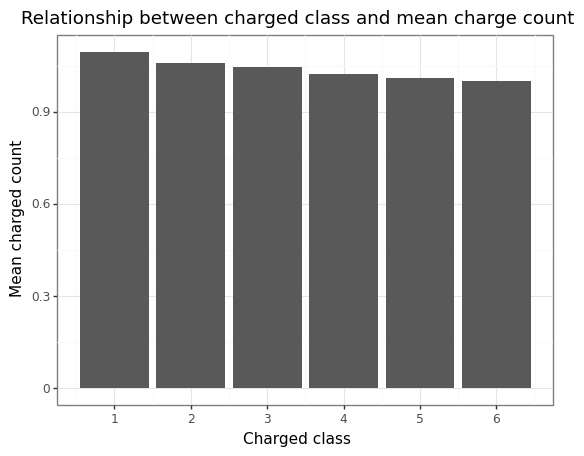

<ggplot: (8765133152473)>

In [179]:
import plotnine
from plotnine import *
new_df_cc = new_df.groupby('DISPOSITION_CHARGED_CLASS').agg(Mean = ('CHARGE_COUNT','mean')).reset_index()
ggplot(new_df_cc, aes(x='DISPOSITION_CHARGED_CLASS',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between charged class and mean charge count',\
     x = 'Charged class', y = 'Mean charged count')+\
scale_x_continuous(breaks=(1,2,3,4,5,6))+\
theme_bw()

### AGE_AT_INCIDENT

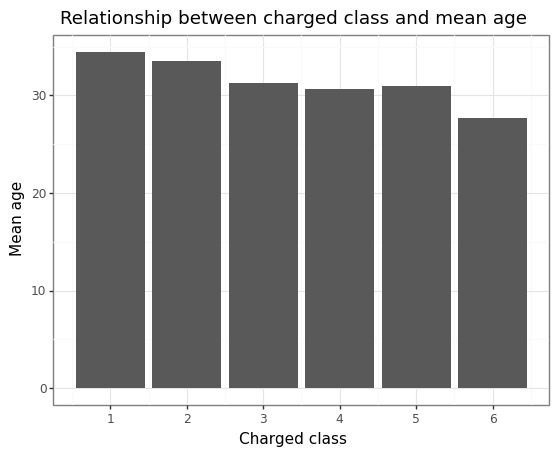

<ggplot: (8765124100714)>

In [160]:
new_df_aai = new_df.groupby('DISPOSITION_CHARGED_CLASS').agg(Mean = ('AGE_AT_INCIDENT','mean')).reset_index()
ggplot(new_df_aai, aes(x='DISPOSITION_CHARGED_CLASS',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between charged class and mean age',\
     x = 'Charged class', y = 'Mean age')+\
scale_x_continuous(breaks=(1,2,3,4,5,6))+\
theme_bw()

### is_changed_offense

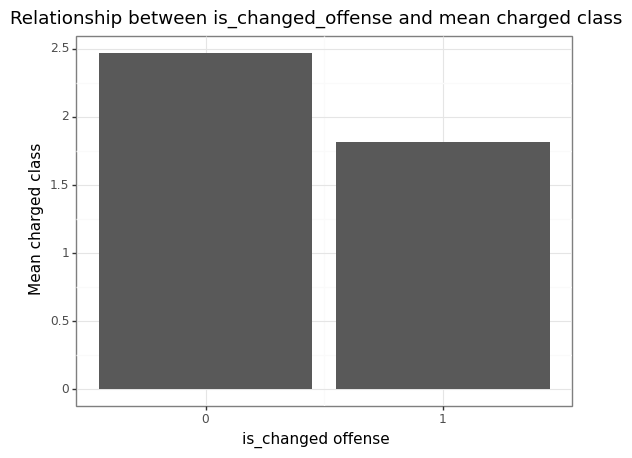

<ggplot: (8765133768677)>

In [162]:
new_df_ico = new_df.groupby('is_changed_offense').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_ico, aes(x='is_changed_offense',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between is_changed_offense and mean charged class',\
     x = 'is_changed offense', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_black_derived			

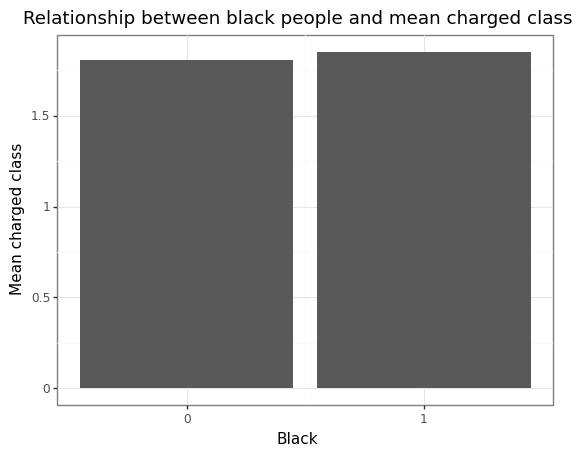

<ggplot: (8765142599533)>

In [163]:
new_df_ibd = new_df.groupby('is_black_derived').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_ibd, aes(x='is_black_derived',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between black people and mean charged class',\
     x = 'Black', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_hisp_derived

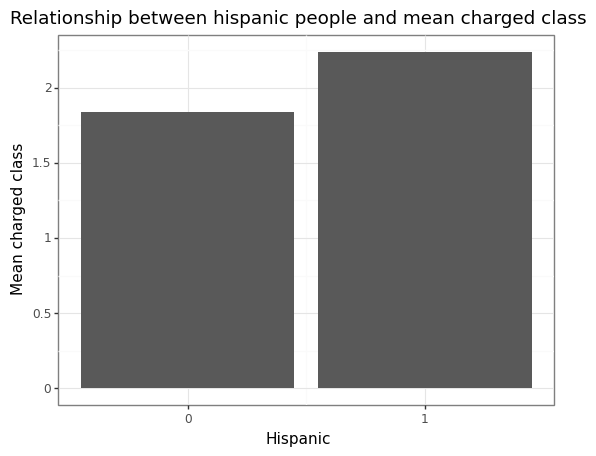

<ggplot: (8765133752763)>

In [164]:
new_df_ihd = new_df.groupby('is_hisp_derived').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_ihd, aes(x='is_hisp_derived',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between hispanic people and mean charged class',\
     x = 'Hispanic', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_other_derived

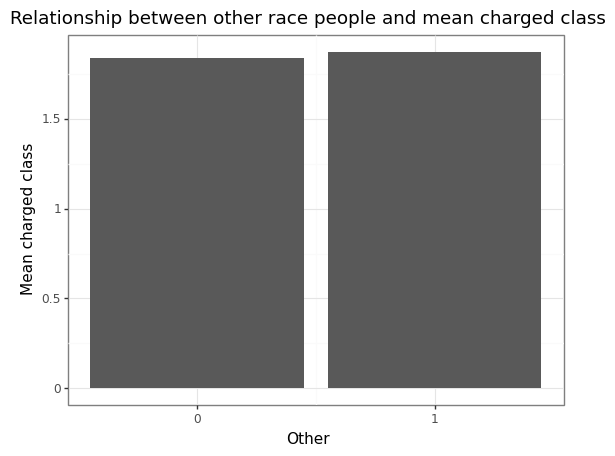

<ggplot: (8765124280513)>

In [165]:
new_df_iod = new_df.groupby('is_other_derived').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_iod, aes(x='is_other_derived',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between other race people and mean charged class',\
     x = 'Other', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_white_derived

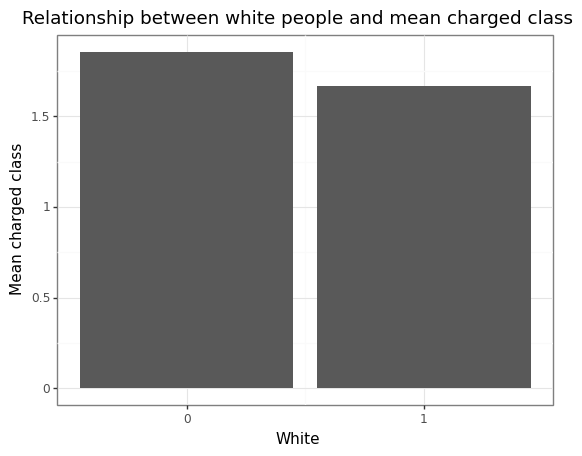

<ggplot: (8765142650456)>

In [166]:
new_df_iwd = new_df.groupby('is_white_derived').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_iwd, aes(x='is_white_derived',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between white people and mean charged class',\
     x = 'White', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_defendant_male						

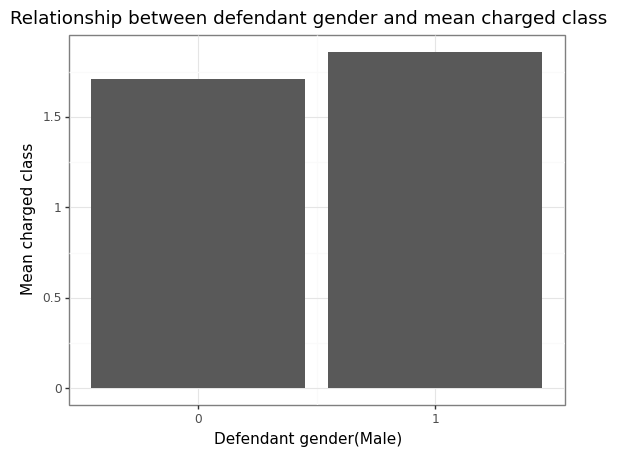

<ggplot: (8765155906341)>

In [167]:
new_df_idm = new_df.groupby('is_defendant_male').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_idm, aes(x='is_defendant_male',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between defendant gender and mean charged class',\
     x = 'Defendant gender(Male)', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_judge_male

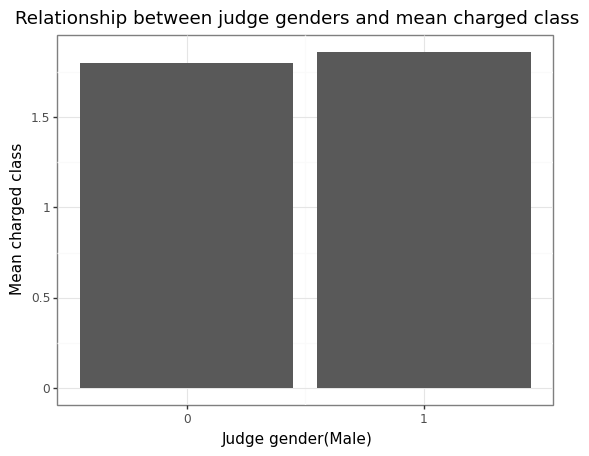

<ggplot: (8765133744978)>

In [168]:
new_df_ijm = new_df.groupby('is_judge_male').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_ijm, aes(x='is_judge_male',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between judge genders and mean charged class',\
     x = 'Judge gender(Male)', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### is_covid

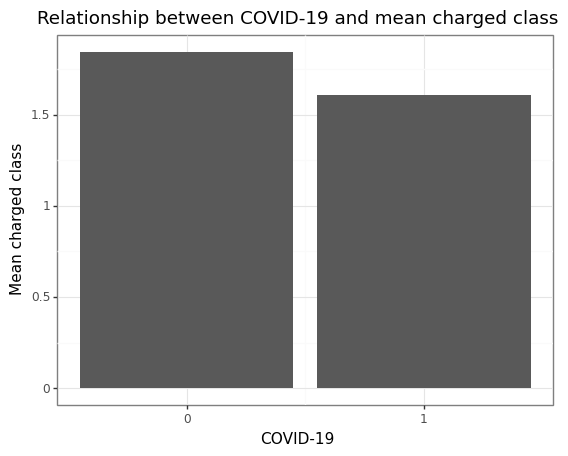

<ggplot: (8765131889529)>

In [169]:
new_df_ic = new_df.groupby('is_covid').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_ic, aes(x='is_covid',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between COVID-19 and mean charged class',\
     x = 'COVID-19', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

### Livability

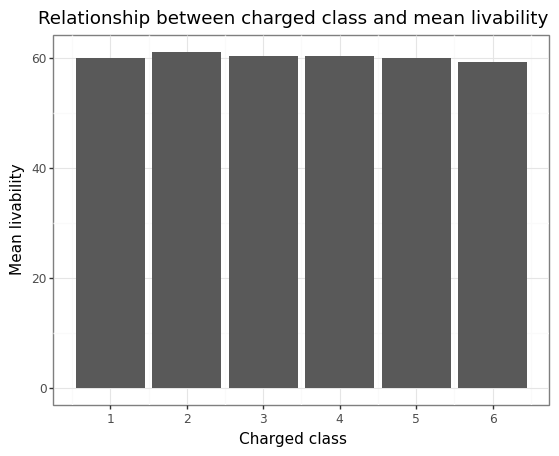

<ggplot: (8765133744996)>

In [170]:
new_df_l = new_df.groupby('DISPOSITION_CHARGED_CLASS').agg(Mean = ('Livability','mean')).reset_index()
ggplot(new_df_l, aes(x='DISPOSITION_CHARGED_CLASS',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between charged class and mean livability',\
     x = 'Charged class', y = 'Mean livability')+\
scale_x_continuous(breaks=(1,2,3,4,5,6))+\
theme_bw()

### his_prop

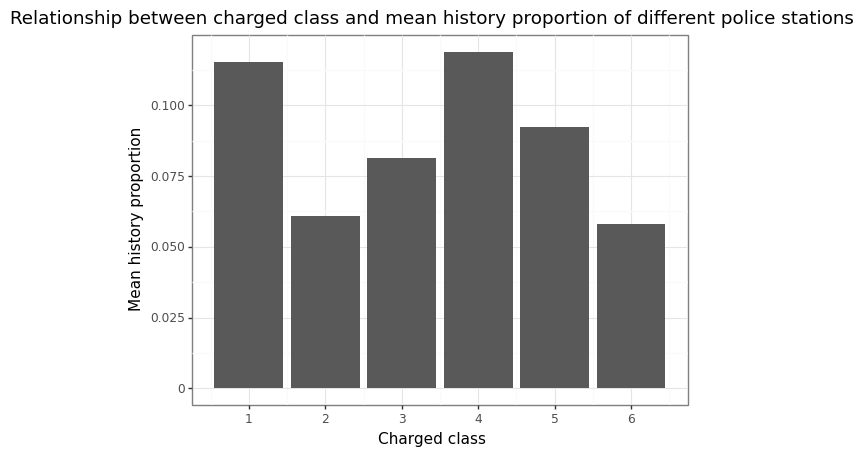

<ggplot: (8765124100690)>

In [171]:
new_df_hp = new_df.groupby('DISPOSITION_CHARGED_CLASS').agg(Mean = ('his_prop','mean')).reset_index()
ggplot(new_df_hp, aes(x='DISPOSITION_CHARGED_CLASS',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between charged class and mean history proportion of different police stations',\
     x = 'Charged class', y = 'Mean history proportion')+\
scale_x_continuous(breaks=(1,2,3,4,5,6))+\
theme_bw()

### senlength_derived

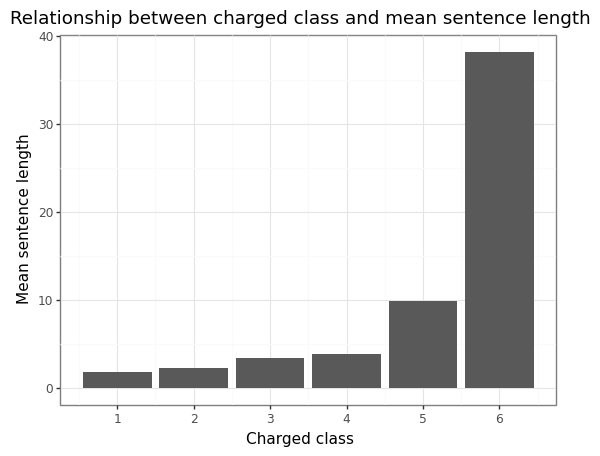

<ggplot: (8765131862504)>

In [172]:
new_df_sd = new_df.groupby('DISPOSITION_CHARGED_CLASS').agg(Mean = ('senlength_derived','mean')).reset_index()
ggplot(new_df_sd, aes(x='DISPOSITION_CHARGED_CLASS',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between charged class and mean sentence length',\
     x = 'Charged class', y = 'Mean sentence length')+\
scale_x_continuous(breaks=(1,2,3,4,5,6))+\
theme_bw()

### Incar

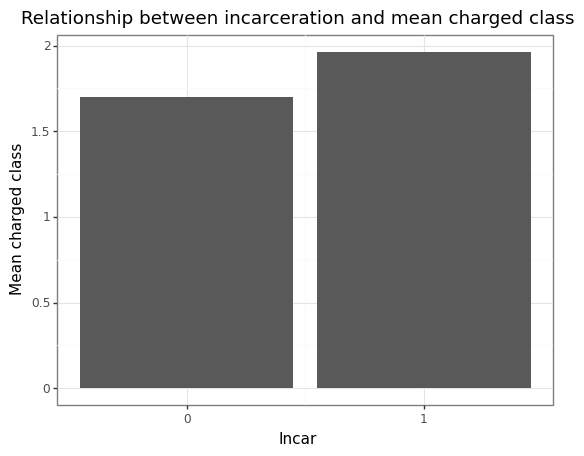

<ggplot: (8765125976324)>

In [183]:
new_df_i = new_df.groupby('Incar').agg(Mean = ('DISPOSITION_CHARGED_CLASS','mean')).reset_index()
ggplot(new_df_i, aes(x='Incar',y='Mean')) +\
geom_col() +\
labs(title = 'Relationship between incarceration and mean charged class',\
     x = 'Incar', y = 'Mean charged class')+\
scale_x_continuous(breaks=(0,1))+\
theme_bw()

## Linear Regression Model Results
### We choose linear regression model to do regression

In [69]:
## Get y_variable
y = pd.DataFrame(new_df.DISPOSITION_CHARGED_CLASS)
## Get X variable
X = pd.DataFrame(new_df.drop(['DISPOSITION_CHARGED_CLASS'], axis = 1))

In [70]:
## Add constant of X variable
import statsmodels.api as sm
X = sm.add_constant(X)

## Train the model
model = sm.OLS(y, X).fit()
## See the regression results
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     DISPOSITION_CHARGED_CLASS   R-squared:                       0.267
Model:                                   OLS   Adj. R-squared:                  0.267
Method:                        Least Squares   F-statistic:                     1328.
Date:                       Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                               18:05:20   Log-Likelihood:                -69110.
No. Observations:                      47295   AIC:                         1.382e+05
Df Residuals:                          47281   BIC:                         1.384e+05
Df Model:                                 13                                         
Covariance Type:                   nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

We can see is_defendant_male, is_covid have no relevant with y variable, is_judge_male has less relevant with y variable.

In [71]:
# Summary of regression coefficient table
coef_df = pd.DataFrame({"params": model.params,   # Coefficient
                        "std err": model.bse,     # Standard deviation of regression coefficient
                        "t": round(model.tvalues,3),       # t-value
                        "p-values": round(model.pvalues,3) # P-value
                         })

coef_df[['coef_0.025','coef_0.975']] = model.conf_int() # The regression coefficient confidence interval defaults to 5%
coef_df

,params,std err,t,p-values,coef_0.025,coef_0.975
const,1.547381,0.057072,27.113,0.000,1.435518,1.659243
CHARGE_COUNT,-0.069650,0.007985,-8.723,0.000,-0.085300,-0.054000
AGE_AT_INCIDENT,-0.011211,0.000397,-28.255,0.000,-0.011989,-0.010433
is_changed_offense,-0.380875,0.023778,-16.018,0.000,-0.427481,-0.334269
is_black_derived,0.385768,0.023633,16.323,0.000,0.339447,0.432090
is_hisp_derived,0.599746,0.079631,7.532,0.000,0.443669,0.755824
is_other_derived,0.334120,0.026202,12.752,0.000,0.282763,0.385476
is_white_derived,0.227747,0.028628,7.955,0.000,0.171635,0.283858
is_defendant_male,-0.011620,0.015654,-0.742,0.458,-0.042302,0.019063
is_judge_male,0.022584,0.010797,2.092,0.036,0.001422,0.043746


## Test different models to predict which charged type the people will be sentenced

In [72]:
y = new_df.DISPOSITION_CHARGED_CLASS
X = new_df.drop(['DISPOSITION_CHARGED_CLASS'], axis = 1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=6) 
feature_list = list(X.columns)

In [73]:
## Describe the training and test shape
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (35471, 14)
Training Labels Shape: (35471,)
Testing Features Shape: (11824, 14)
Testing Labels Shape: (11824,)


### Logistic Regression Model

In [74]:
## Create Logistic Regression Model
from sklearn.linear_model import LogisticRegression 

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

## Get the accuracy of train data set
log_reg.score(X_train,y_train)

/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6642891376053678

In [75]:
## Get the accuracy of test data set
log_reg.score(X_test,y_test)

0.6627198917456022

In [77]:
## The MSE or RMSE (mean square error root) is usually used to evaluate the model
## The smaller the value, the closer the predicted value is to the true value
## The RMSE of train data set
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = log_reg.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.1187933547636753

In [78]:
## The RMSE of test data set
y_pred = log_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
rmse

1.1143591640104518

In [84]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.98      0.82      7420
           2       0.00      0.00      0.00       956
           3       0.32      0.22      0.26      1822
           4       0.32      0.07      0.11      1244
           5       0.61      0.31      0.41       360
           6       0.56      0.45      0.50        22

    accuracy                           0.66     11824
   macro avg       0.42      0.34      0.35     11824
weighted avg       0.55      0.66      0.58     11824



/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [87]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_pred}, columns=['Real','Predict']).head(10)

,Real,Predict
8644,1,1
44774,1,1
19090,1,1
22116,1,1
24332,3,1
40613,1,1
39053,1,1
41290,1,1
19860,1,1
34609,1,1


In [88]:
## Get the matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix

array([[7236,    0,  170,    3,   10,    1],
       [ 894,    0,   55,    4,    3,    0],
       [1330,    0,  392,   86,   14,    0],
       [ 633,    0,  492,   85,   34,    0],
       [  31,    0,  122,   87,  113,    7],
       [   1,    0,    0,    0,   11,   10]])

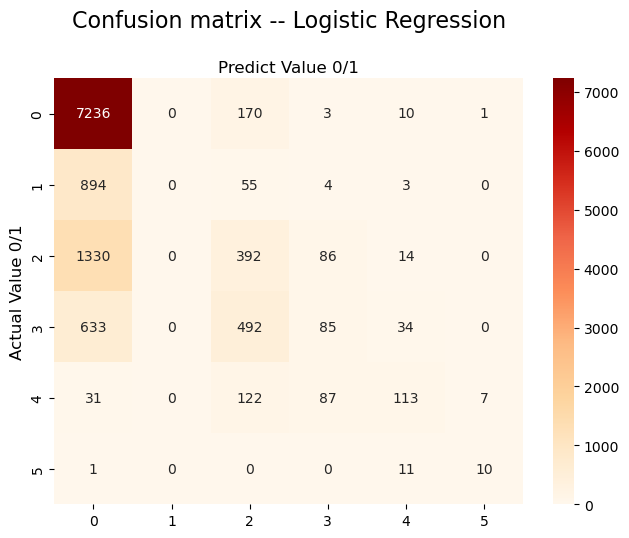

In [90]:
## Plot the matrix
import matplotlib.pyplot as plt
def plot_cnf_matirx(cnf_matrix,description):
    class_names = [0,1]
    fig,ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks,class_names)
    plt.yticks(tick_marks,class_names)

# Create a heat map
    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'OrRd',
               fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title(description, y = 1.1,fontsize=16)
    plt.ylabel('Actual Value 0/1',fontsize=12)
    plt.xlabel('Predict Value 0/1',fontsize=12)
    plt.show()
    
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- Logistic Regression')

### KNN Model

In [145]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
param_grid = [
    {
        'weights':['uniform'],
        'n_neighbors':[i for i in range(1,30)]
    },
    {
        'weights':['distance'],
        'n_neighbors':[i for i in range(1,30)],
        'p':[i for i in range(1,4)]
    }
]
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(knn_model,param_grid)

grid_search.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29],
                          'weights': ['uniform']},
                         {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29],
                          'p': [1, 2, 3], 'weights': ['distance']}])

In [146]:
## To see the optimal model information
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=20)

In [147]:
## The score of train model
knn_clf = grid_search.best_estimator_
knn_clf.score(X_train,y_train)

0.7096501367314144

In [148]:
## The score of test model
knn_clf.score(X_test,y_test)

0.6932510148849798

In [149]:
## The RMSE of train data set
train_preds = knn_clf.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.0746042632923702

In [150]:
## The RMSE of test data set
y_predict_knn = knn_clf.predict(X_test)
mse  = metrics.mean_squared_error(y_test, y_predict_knn)
rmse = sqrt(mse)
rmse

1.0987291219203605

In [151]:
## Get F1-score
print(classification_report(y_test,y_predict_knn))

              precision    recall  f1-score   support

           1       0.73      0.97      0.84      7420
           2       0.26      0.01      0.03       956
           3       0.52      0.33      0.41      1822
           4       0.43      0.19      0.26      1244
           5       0.55      0.39      0.45       360
           6       0.62      0.36      0.46        22

    accuracy                           0.69     11824
   macro avg       0.52      0.38      0.41     11824
weighted avg       0.63      0.69      0.63     11824



In [152]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_knn}, columns=['Real','Predict']).head(10)

,Real,Predict
8644,1,1
44774,1,1
19090,1,1
22116,1,1
24332,3,1
40613,1,1
39053,1,1
41290,1,1
19860,1,1
34609,1,1


In [153]:
## Get the matrix
cnf_matrix = confusion_matrix(y_test,y_predict_knn)
cnf_matrix

array([[7195,   16,  152,   45,   11,    1],
       [ 853,   14,   64,   20,    5,    0],
       [1023,   17,  610,  143,   29,    0],
       [ 694,    6,  259,  231,   54,    0],
       [  36,    0,   84,   97,  139,    4],
       [   1,    0,    0,    0,   13,    8]])

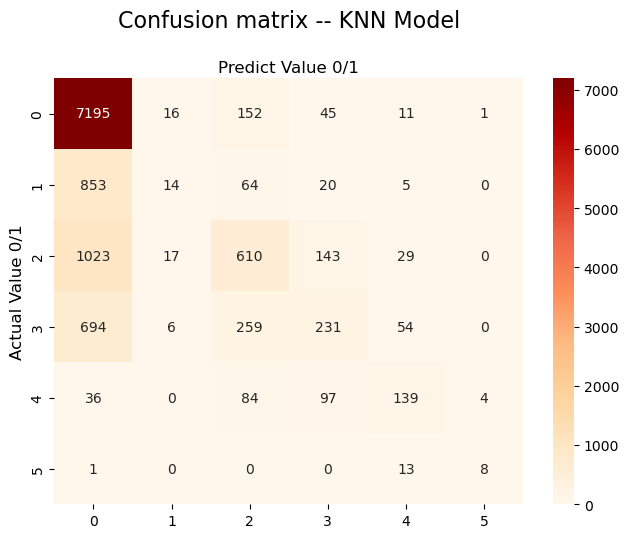

In [154]:
# Plot the matrix graph
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- KNN Model')

### Decision Tree Model

In [92]:
from sklearn.tree import DecisionTreeClassifier
dt_clf= DecisionTreeClassifier(random_state=6)

In [93]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]
    }
]
grid_search = GridSearchCV(dt_clf,param_grid)

grid_search.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=6),
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11],
                          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                12, 13, 14, 15, 16, 17, 18]}])

In [94]:
## To see the optimal model information
grid_search.best_estimator_

DecisionTreeClassifier(max_features='auto', min_samples_leaf=4,
                       min_samples_split=18, random_state=6)

In [95]:
## The score of train model
dt_clf = grid_search.best_estimator_
dt_clf.score(X_train,y_train)

0.6994728087733642

In [96]:
## The score of test model
dt_clf.score(X_test,y_test)

0.6716847090663058

In [97]:
## The RMSE of train data set
train_preds = dt_clf.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.1098371967843437

In [98]:
## The RMSE of test data set
y_predict_dt = dt_clf.predict(X_test)
mse = mean_squared_error(y_test, y_predict_dt)
rmse = sqrt(mse)
rmse

1.147377429693691

In [99]:
## Get F1-score
print(classification_report(y_test,y_predict_dt))

              precision    recall  f1-score   support

           1       0.75      0.93      0.83      7420
           2       0.33      0.11      0.17       956
           3       0.42      0.42      0.42      1822
           4       0.43      0.14      0.21      1244
           5       0.40      0.09      0.14       360
           6       0.00      0.00      0.00        22

    accuracy                           0.67     11824
   macro avg       0.39      0.28      0.29     11824
weighted avg       0.62      0.67      0.62     11824



/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [100]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_dt}, columns=['Real','Predict']).head(10)

,Real,Predict
8644,1,1
44774,1,1
19090,1,1
22116,1,1
24332,3,1
40613,1,1
39053,1,1
41290,1,2
19860,1,1
34609,1,1


In [101]:
## Plot the matrix
cnf_matrix = confusion_matrix(y_test,y_predict_dt)
cnf_matrix

array([[6868,  130,  370,   49,    3,    0],
       [ 733,  106,   99,   14,    4,    0],
       [ 872,   49,  766,  116,   19,    0],
       [ 662,   28,  364,  171,   19,    0],
       [  75,    5,  200,   49,   31,    0],
       [   5,    1,   13,    2,    1,    0]])

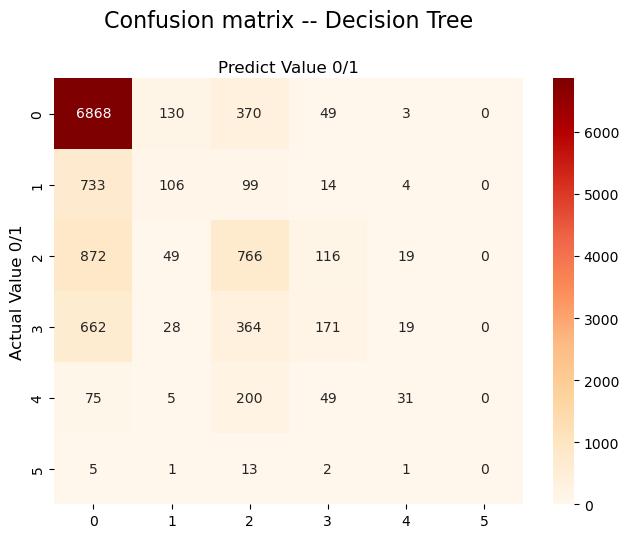

In [102]:
## Plot the heat graph
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- Decision Tree')

In [103]:
# Get numerical feature importances
importances = list(dt_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.64
Variable: AGE_AT_INCIDENT      Importance: 0.11
Variable: his_prop             Importance: 0.09
Variable: Livability           Importance: 0.05
Variable: Incar                Importance: 0.04
Variable: is_changed_offense   Importance: 0.02
Variable: CHARGE_COUNT         Importance: 0.01
Variable: is_black_derived     Importance: 0.01
Variable: is_other_derived     Importance: 0.01
Variable: is_white_derived     Importance: 0.01
Variable: is_defendant_male    Importance: 0.01
Variable: is_judge_male        Importance: 0.01
Variable: is_hisp_derived      Importance: 0.0
Variable: is_covid             Importance: 0.0


### Random Forest Model

In [104]:
param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[5, 6, 7, 8],    
    'n_estimators':[11,13,15], 
    'max_features':[0.3,0.4,0.5],
    'min_samples_split':[4,8,12,16]  
}

import sklearn.ensemble as ensemble 
from sklearn.ensemble import RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier()
grid_search = GridSearchCV(rf_clf,param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 6, 7, 8],
                         'max_features': [0.3, 0.4, 0.5],
                         'min_samples_split': [4, 8, 12, 16],
                         'n_estimators': [11, 13, 15]})

In [105]:
## To see the optimal model information
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.5,
                       min_samples_split=4, n_estimators=15)

In [106]:
## The score of train model
rf_clf = grid_search.best_estimator_
rf_clf.score(X_train,y_train)

0.7252121451326435

In [107]:
## The score of test model
rf_clf.score(X_test,y_test)

0.7126184032476319

In [108]:
## The RMSE of train data set
train_preds = rf_clf.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.0495061539096595

In [109]:
## The RMSE of test data set
y_predict_rf = rf_clf.predict(X_test)
mse = mean_squared_error(y_test, y_predict_rf)
rmse = sqrt(mse)
rmse

1.0609790714177487

In [110]:
## Get F1-score
print(classification_report(y_test,y_predict_rf))

              precision    recall  f1-score   support

           1       0.76      0.95      0.84      7420
           2       0.59      0.12      0.21       956
           3       0.56      0.39      0.46      1822
           4       0.51      0.27      0.35      1244
           5       0.52      0.47      0.49       360
           6       0.46      0.27      0.34        22

    accuracy                           0.71     11824
   macro avg       0.57      0.41      0.45     11824
weighted avg       0.68      0.71      0.67     11824



In [111]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_rf}, columns=['Real','Predict']).head(10)

,Real,Predict
8644,1,1
44774,1,1
19090,1,1
22116,1,1
24332,3,1
40613,1,1
39053,1,1
41290,1,2
19860,1,1
34609,1,1


In [112]:
## Plot the matrix
cnf_matrix = confusion_matrix(y_test,y_predict_rf)
cnf_matrix

array([[7080,   69,  214,   53,    4,    0],
       [ 727,  119,   83,   22,    5,    0],
       [ 870,    9,  715,  179,   49,    0],
       [ 650,    5,  171,  338,   80,    0],
       [  29,    0,   83,   73,  168,    7],
       [   1,    0,    0,    0,   15,    6]])

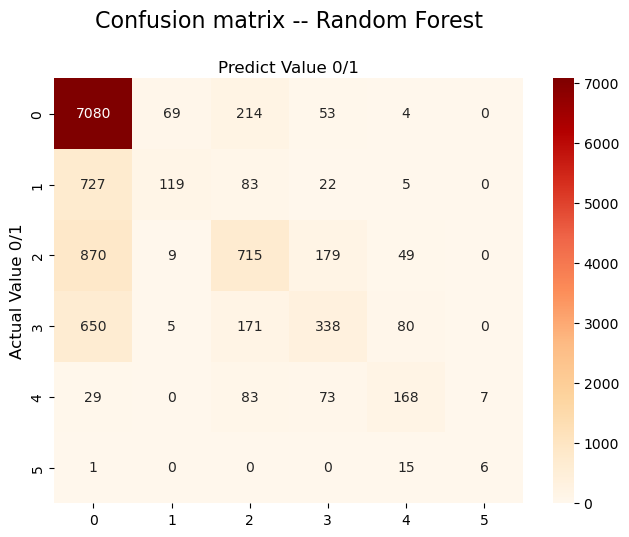

In [113]:
## Plot the heat graph
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- Random Forest')

In [114]:
# Get numerical feature importances
importances = list(rf_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.69
Variable: his_prop             Importance: 0.09
Variable: Incar                Importance: 0.09
Variable: AGE_AT_INCIDENT      Importance: 0.08
Variable: Livability           Importance: 0.02
Variable: is_changed_offense   Importance: 0.01
Variable: is_black_derived     Importance: 0.01
Variable: is_other_derived     Importance: 0.01
Variable: is_white_derived     Importance: 0.01
Variable: CHARGE_COUNT         Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_defendant_male    Importance: 0.0
Variable: is_judge_male        Importance: 0.0
Variable: is_covid             Importance: 0.0


### Refined Decision Tree Model

In [115]:
from sklearn.tree import DecisionTreeClassifier
dt_clf1= DecisionTreeClassifier(random_state=42)

In [116]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    }
]
grid_search = GridSearchCV(dt_clf,param_grid)

grid_search.fit(X_train,y_train)

/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split

GridSearchCV(estimator=DecisionTreeClassifier(max_features='auto',
                                              min_samples_leaf=4,
                                              min_samples_split=18,
                                              random_state=6),
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20],
                          'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19, 20]}])

In [118]:
## To see the optimal model information
grid_search.best_estimator_

DecisionTreeClassifier(max_features='auto', min_samples_leaf=4,
                       min_samples_split=18, random_state=6)

In [119]:
## The score of train model
dt_clf1 = grid_search.best_estimator_
dt_clf1.score(X_train,y_train)

0.6994728087733642

In [120]:
## The score of test model
dt_clf1.score(X_test,y_test)

0.6716847090663058

In [121]:
## The RMSE of train data set
train_preds1 = dt_clf1.predict(X_train)
mse = mean_squared_error(y_train, train_preds1)
rmse = sqrt(mse)
rmse

1.1098371967843437

In [122]:
## The RMSE of test data set
y_predict_dt1 = dt_clf1.predict(X_test)
mse = mean_squared_error(y_test, y_predict_dt1)
rmse = sqrt(mse)
rmse

1.147377429693691

In [123]:
## Get F1-score
print(classification_report(y_test,y_predict_dt1))

              precision    recall  f1-score   support

           1       0.75      0.93      0.83      7420
           2       0.33      0.11      0.17       956
           3       0.42      0.42      0.42      1822
           4       0.43      0.14      0.21      1244
           5       0.40      0.09      0.14       360
           6       0.00      0.00      0.00        22

    accuracy                           0.67     11824
   macro avg       0.39      0.28      0.29     11824
weighted avg       0.62      0.67      0.62     11824



/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [124]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_dt1}, columns=['Real','Predict']).head(10)

,Real,Predict
8644,1,1
44774,1,1
19090,1,1
22116,1,1
24332,3,1
40613,1,1
39053,1,1
41290,1,2
19860,1,1
34609,1,1


In [125]:
## Plot the matrix
cnf_matrix = confusion_matrix(y_test,y_predict_dt1)
cnf_matrix

array([[6868,  130,  370,   49,    3,    0],
       [ 733,  106,   99,   14,    4,    0],
       [ 872,   49,  766,  116,   19,    0],
       [ 662,   28,  364,  171,   19,    0],
       [  75,    5,  200,   49,   31,    0],
       [   5,    1,   13,    2,    1,    0]])

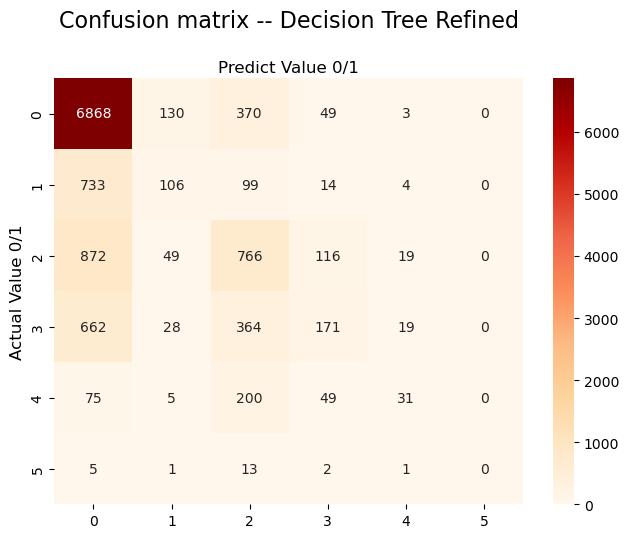

In [126]:
## Plot the heat graph
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- Decision Tree Refined')

In [127]:
# Get numerical feature importances
importances = list(dt_clf1.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.64
Variable: AGE_AT_INCIDENT      Importance: 0.11
Variable: his_prop             Importance: 0.09
Variable: Livability           Importance: 0.05
Variable: Incar                Importance: 0.04
Variable: is_changed_offense   Importance: 0.02
Variable: CHARGE_COUNT         Importance: 0.01
Variable: is_black_derived     Importance: 0.01
Variable: is_other_derived     Importance: 0.01
Variable: is_white_derived     Importance: 0.01
Variable: is_defendant_male    Importance: 0.01
Variable: is_judge_male        Importance: 0.01
Variable: is_hisp_derived      Importance: 0.0
Variable: is_covid             Importance: 0.0


### Refined Random Forest Model

In [128]:
param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[8,9,10,11,12,13],    
    'n_estimators':[15,17,19,21,23], 
    'max_features':[0.5,0.6,0.7,0.8],
    'min_samples_split':[1,2,3,4]  
}

import sklearn.ensemble as ensemble 
from sklearn.ensemble import RandomForestClassifier
rf_clf1 = ensemble.RandomForestClassifier()
grid_search = GridSearchCV(rf_clf1,param_grid)
grid_search.fit(X_train, y_train)

/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1200 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [8, 9, 10, 11, 12, 13],
                         'max_features': [0.5, 0.6, 0.7, 0.8],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [15, 17, 19, 21, 23]})

In [129]:
## To see the optimal model information
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9, max_features=0.7,
                       min_samples_split=4, n_estimators=17)

In [130]:
## The score of train model
rf_clf1 = grid_search.best_estimator_
rf_clf1.score(X_train,y_train)

0.7331623015984889

In [131]:
## The score of test model
rf_clf1.score(X_test,y_test)

0.7153247631935047

In [132]:
## The RMSE of train data set
train_preds2 = rf_clf1.predict(X_train)
mse = mean_squared_error(y_train, train_preds2)
rmse = sqrt(mse)
rmse

1.0395874251853372

In [133]:
## The RMSE of test data set
y_predict_rf1 = rf_clf1.predict(X_test)
mse = mean_squared_error(y_test, y_predict_rf1)
rmse = sqrt(mse)
rmse

1.0587048154858285

In [134]:
## Get F1-score
print(classification_report(y_test,y_predict_rf1))

              precision    recall  f1-score   support

           1       0.76      0.95      0.84      7420
           2       0.57      0.12      0.20       956
           3       0.59      0.40      0.47      1822
           4       0.50      0.30      0.37      1244
           5       0.57      0.44      0.50       360
           6       0.45      0.41      0.43        22

    accuracy                           0.72     11824
   macro avg       0.57      0.44      0.47     11824
weighted avg       0.68      0.72      0.67     11824



In [135]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_rf1}, columns=['Real','Predict']).head(10)

,Real,Predict
8644,1,1
44774,1,1
19090,1,1
22116,1,1
24332,3,1
40613,1,1
39053,1,1
41290,1,2
19860,1,1
34609,1,1


In [136]:
## Plot the matrix
cnf_matrix1 = confusion_matrix(y_test,y_predict_rf1)
cnf_matrix1

array([[7085,   66,  198,   68,    2,    1],
       [ 732,  114,   79,   27,    4,    0],
       [ 863,   10,  725,  189,   35,    0],
       [ 645,   10,  153,  367,   68,    1],
       [  29,    0,   76,   88,  158,    9],
       [   1,    0,    1,    0,   11,    9]])

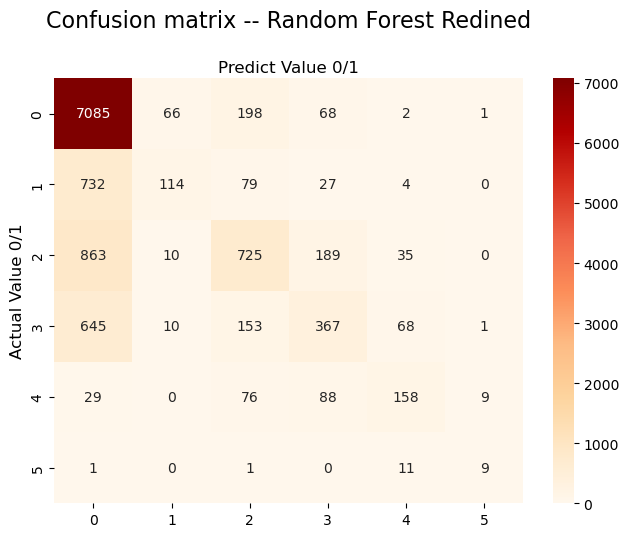

In [137]:
## Plot the heat graph
plot_cnf_matirx(cnf_matrix1,'Confusion matrix -- Random Forest Redined')

In [138]:
# Get numerical feature importances
importances = list(rf_clf1.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.64
Variable: AGE_AT_INCIDENT      Importance: 0.1
Variable: his_prop             Importance: 0.09
Variable: Incar                Importance: 0.08
Variable: Livability           Importance: 0.03
Variable: is_changed_offense   Importance: 0.01
Variable: is_black_derived     Importance: 0.01
Variable: is_other_derived     Importance: 0.01
Variable: is_white_derived     Importance: 0.01
Variable: is_defendant_male    Importance: 0.01
Variable: is_judge_male        Importance: 0.01
Variable: CHARGE_COUNT         Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_covid             Importance: 0.0


### View the prediction Result

In [159]:
pd.DataFrame({'Real':y_test,'Logistic Regression':y_pred, 'KNN':y_predict_knn, 'Decision Tree':y_predict_dt,
              'Random Forest':y_predict_rf, 'Decision Tree Refined':y_predict_dt1,
              'Random Forest Refined':y_predict_rf1}).reset_index().drop(columns='index').head(10)

,Real,Logistic Regression,KNN,Decision Tree,Random Forest,Decision Tree Refined,Random Forest Refined
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,3,1,1,1,1,1,1
5,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1
7,1,1,1,2,2,2,2
8,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1


### Compare the model results

In [155]:
Logistic_score = log_reg.score(X_test,y_test)
KNN_score = knn_clf.score(X_test,y_test)
dt_score = dt_clf.score(X_test,y_test)
rf_score = rf_clf.score(X_test,y_test)
dt_refine_score = dt_clf1.score(X_test,y_test)
rf_refine_score = rf_clf1.score(X_test,y_test)

In [156]:
model_result = pd.DataFrame({
    'Model': [ 'Logistic Regression Model', 'KNN Model', 'Decision Tree Model','Random Forest Model', \
              'Decision Tree Model Refined','Random Forest Model Refined'],
    'Score': [ Logistic_score, KNN_score, dt_score, rf_score, dt_refine_score, rf_refine_score]})
model_result.sort_values(by='Score', ascending=False)

,Model,Score
5,Random Forest Model Refined,0.715325
3,Random Forest Model,0.712618
1,KNN Model,0.693251
2,Decision Tree Model,0.671685
4,Decision Tree Model Refined,0.671685
0,Logistic Regression Model,0.662720


### Plot the feature importances together

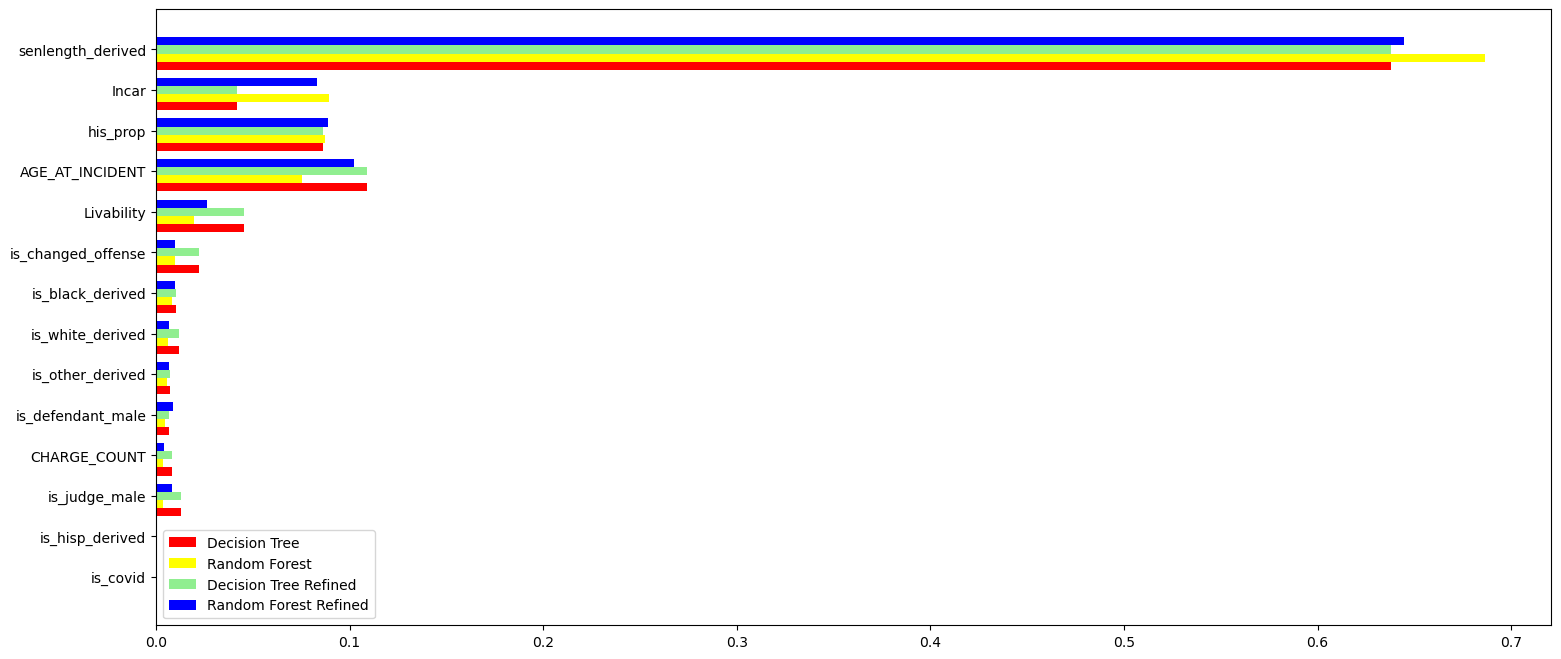

In [143]:
## Compare the feature importances of Random Forest and Decision Tree
feature_importance1=pd.DataFrame({
    'dt':dt_clf.feature_importances_,
    'rfc':rf_clf.feature_importances_,
    'dt_refine':dt_clf1.feature_importances_,
    'rfc_refine':rf_clf1.feature_importances_
},index=new_df.drop(['DISPOSITION_CHARGED_CLASS'], axis = 1).columns)
feature_importance1.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance1))
fig, ax = plt.subplots(figsize=(18,8))
dt_feature=ax.barh(index,feature_importance1['dt'],0.2,color='red',label='Decision Tree')
rfc_feature=ax.barh(index+0.2,feature_importance1['rfc'],0.2,color='yellow',label='Random Forest')
dt_refine_feature=ax.barh(index+0.4,feature_importance1['dt_refine'],0.2,color='lightgreen',label='Decision Tree Refined')
rfc_refine_feature=ax.barh(index+0.6,feature_importance1['rfc_refine'],0.2,color='blue',label='Random Forest Refined')
ax.set(yticks=index+0.4,yticklabels=feature_importance1.index)

ax.legend()
plt.show()